In [24]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import datasets
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, recall_score, precision_score, f1_score
import missingno as msno
import pgeocode
import xgboost as xgb
from sklearn.preprocessing import TargetEncoder, LabelEncoder
import scipy.stats as stats
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
import re
import shap


In [25]:
df = pd.read_csv("datacleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 30 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   LoanNr_ChkDgt       899164 non-null  int64  
 1   Name                899150 non-null  object 
 2   City                899164 non-null  object 
 3   State               899164 non-null  object 
 4   Zip                 899164 non-null  int64  
 5   Bank                897605 non-null  object 
 6   BankState           897598 non-null  object 
 7   NAICS               899164 non-null  int64  
 8   ApprovalDate        899164 non-null  object 
 9   ApprovalFY          899164 non-null  int64  
 10  Term                899164 non-null  int64  
 11  NoEmp               899164 non-null  int64  
 12  NewExist            899028 non-null  float64
 13  CreateJob           899164 non-null  int64  
 14  RetainedJob         899164 non-null  int64  
 15  FranchiseCode       899164 non-nul

convert nan to string

In [26]:
df.isna().sum()

LoanNr_ChkDgt              0
Name                      14
City                       0
State                      0
Zip                        0
Bank                    1559
BankState               1566
NAICS                      0
ApprovalDate               0
ApprovalFY                 0
Term                       0
NoEmp                      0
NewExist                 136
CreateJob                  0
RetainedJob                0
FranchiseCode              0
UrbanRural                 0
RevLineCr               4528
LowDoc                     0
ChgOffDate            736465
DisbursementDate        2368
DisbursementGross          0
BalanceGross               0
MIS_Status                 0
ChgOffPrinGr               0
GrAppv                     0
SBA_Appv                   0
domaine d’activite         0
activities                 0
Franchise                  0
dtype: int64

df['NewExist'] = df['NewExist'].apply(lambda x: "NaN" if x == np.nan else x)
df['UrbanRural'] = df['UrbanRural'].apply(lambda x: str(x))
df['RevLineCr'] = df['RevLineCr'].apply(lambda x: "NaN" if x == np.nan else x)


df['NewExist'] = df['NewExist'].astype('str')
df['UrbanRural'] = df['UrbanRural'].astype('str')
df['GrAppv'] = df['GrAppv'].astype('str')
df

df["UrbanRural"].value_counts() 

In [27]:
data = df.drop(["LoanNr_ChkDgt","ApprovalFY", "domaine d’activite","FranchiseCode", "ChgOffDate", "DisbursementDate", "DisbursementGross", "BalanceGross", "ChgOffPrinGr", "SBA_Appv", "Name", "City", "Zip", "Bank", "BankState", "NAICS", "RevLineCr", "ApprovalDate"], axis=1)

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   State        899164 non-null  object 
 1   Term         899164 non-null  int64  
 2   NoEmp        899164 non-null  int64  
 3   NewExist     899028 non-null  float64
 4   CreateJob    899164 non-null  int64  
 5   RetainedJob  899164 non-null  int64  
 6   UrbanRural   899164 non-null  int64  
 7   LowDoc       899164 non-null  object 
 8   MIS_Status   899164 non-null  int64  
 9   GrAppv       899164 non-null  float64
 10  activities   899164 non-null  object 
 11  Franchise    899164 non-null  int64  
dtypes: float64(2), int64(7), object(3)
memory usage: 82.3+ MB


In [29]:
data.dtypes

State           object
Term             int64
NoEmp            int64
NewExist       float64
CreateJob        int64
RetainedJob      int64
UrbanRural       int64
LowDoc          object
MIS_Status       int64
GrAppv         float64
activities      object
Franchise        int64
dtype: object

categorical_features = [
    'MIS_Status',
    'City',
    'State',
    'Bank',
    'BankState',
    'NewExist',
    'UrbanRural',
    'RevLineCr',
    'LowDoc',
    'Industry',
    'FranchiseCode_Encoded',
    'RealEstate_Backed',
    'Region'
]

for col in categorical_features:
    df[col] = df[col].fillna('unknown').astype(str)

In [30]:
X = data.drop("MIS_Status", axis=1)
y = data["MIS_Status"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='F1',
    verbose=100
)

In [32]:
# Détecter automatiquement les  catégories
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Obtenir les indices de ces colonnes
categorical_features_indices = [X.columns.get_loc(col) for col in categorical_features]

# Créer les pools de données
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)


In [33]:
# Créer des pools de données pour CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
test_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

# Entraînement
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)


0:	learn: 0.9282309	test: 0.9285463	best: 0.9285463 (0)	total: 545ms	remaining: 9m 4s
100:	learn: 0.9593901	test: 0.9593133	best: 0.9593133 (100)	total: 39.7s	remaining: 5m 53s


KeyboardInterrupt: 

In [18]:
# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer la précision
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.9408


# Importance Features 

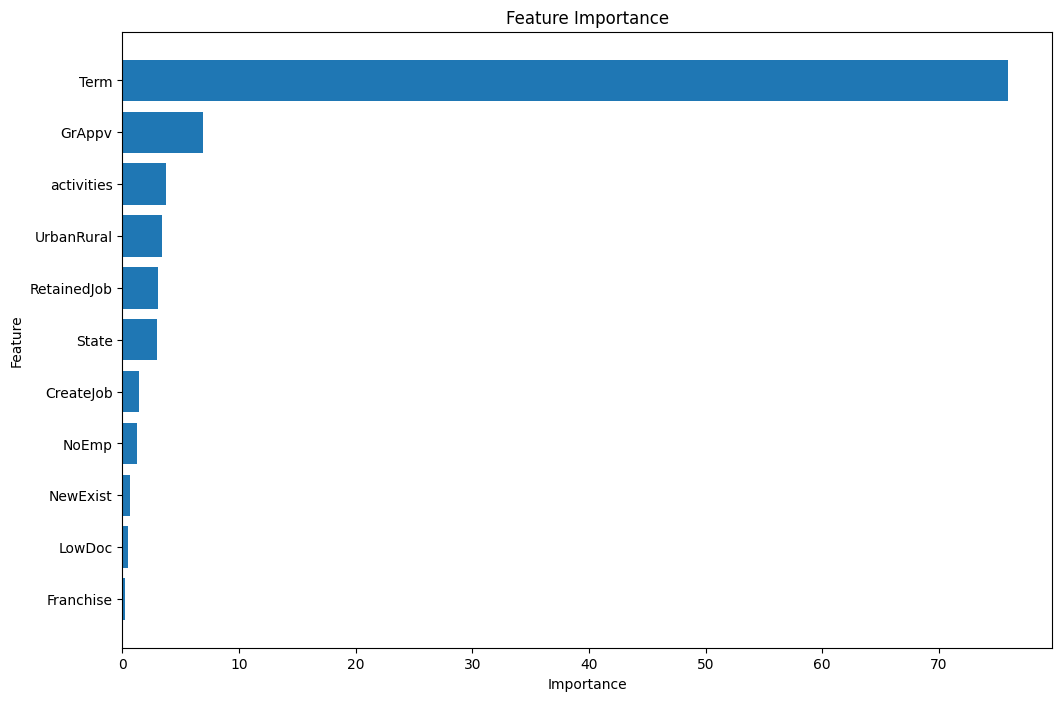

In [19]:
# Get feature importance
feature_importances = model.get_feature_importance(train_pool)
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [13]:
# Sauvegarder le modèle
model.save_model('catboost_model.cbm')




In [59]:
# Charger le modèle
from_file = CatBoostClassifier()
model_test = from_file.load_model('catboost_model.cbm')


In [ ]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.79      0.83     32413
           1       0.96      0.97      0.96    147420

    accuracy                           0.94    179833
   macro avg       0.91      0.88      0.90    179833
weighted avg       0.94      0.94      0.94    179833



# AUC ROC

In [44]:
df.columns

Index(['Unnamed: 0', 'MIS_Status', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc', 'GrAppv',
       'NAICS_class_code', 'Industry', 'FranchiseCode_Encoded',
       'RealEstate_Backed', 'Region', 'TermDays', 'Recession'],
      dtype='object')

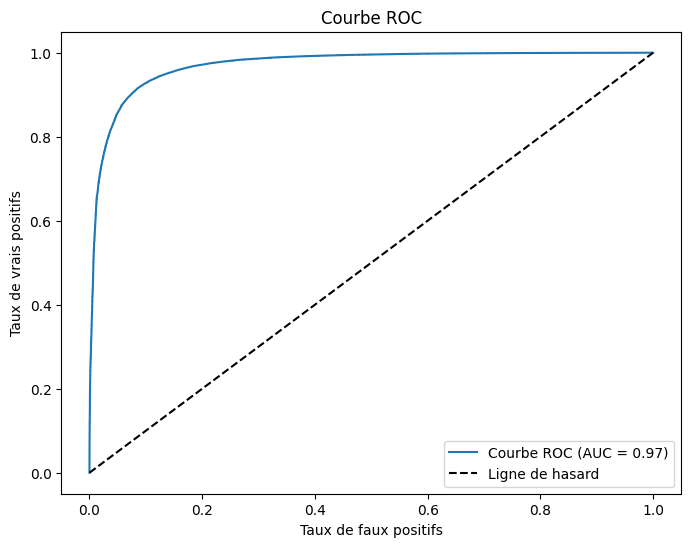

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Prédire les probabilités  
y_proba = model.predict_proba(X_test)[:, 1]

# Calculer le taux de faux positifs (FPR) et le taux de vrais positifs (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculer l'AUC
auc = roc_auc_score(y_test, y_proba)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Courbe ROC (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Ligne de hasard')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()


In [23]:
for feature_name, importance in zip(feature_names, feature_importances):
    print(f"{feature_name}: {importance:.2f}")


State: 2.97
Term: 75.93
NoEmp: 1.23
NewExist: 0.64
CreateJob: 1.39
RetainedJob: 3.08
UrbanRural: 3.45
LowDoc: 0.49
GrAppv: 6.89
activities: 3.71
Franchise: 0.20


# shape Values

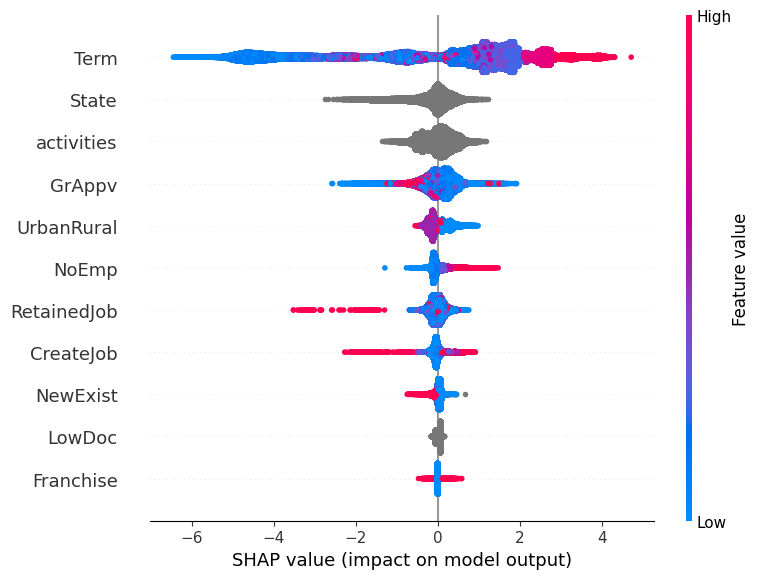

In [22]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)